# Review Data Inspection

In [2]:
import random
random.seed(109)

from pprint import pprint

import os
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

## Review Data

Contains full review text data including the user_id that wrote the review and the business_id the review is written for.

In [3]:
review_df = pd.read_feather('data/yelp_review.feather')
print(f"review data shape: {review_df.shape}")

review data shape: (6990280, 9)


In [4]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 480.0+ MB


In [5]:
review_df.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


### Filter (based on previously selected businesses)

Load cleaned business data:

In [6]:
busi_clean_df = pd.read_feather('data/yelp_business_cleaned.feather')

Filter out reviews for irrelevant businesses:

In [24]:
review_clean_df = review_df.loc[review_df['business_id'].isin(busi_clean_df['business_id'])].copy()

In [26]:
del review_df  # to save memory

In [25]:
print(f"review data shape: {review_clean_df.shape}")

review data shape: (5257329, 9)


We've filtered out about 2 million reviews.

### Data Missingness

In [17]:
review_clean_df.isna().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

Luckily we have no missing data for reviews.

### Feature Scaling

There are 4 numeric features:

In [18]:
review_clean_df.describe()

,stars,useful,funny,cool
count,5.257329e+06,5.257329e+06,5.257329e+06,5.257329e+06
mean,3.804201e+00,1.021837e+00,3.186590e-01,5.057937e-01
std,1.393488e+00,2.792205e+00,1.728878e+00,2.204489e+00
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,4.200000e+02,7.920000e+02,4.040000e+02


We observe that only the `stars` feature is bounded (1-5), and there is much sparcity in the other features: `useful`, `funny`, `cool`. It's often good to practice to perform scaling, so we will do it for all these:

In [27]:
num_cols = ['stars', 'useful', 'funny', 'cool']

# scale
scaler = StandardScaler()
scaled = scaler.fit_transform(review_clean_df.loc[:, num_cols])

# put scaled values into original data frame
review_clean_df.drop(num_cols, axis=1, inplace=True)
review_clean_df = pd.concat([review_clean_df,
                             pd.DataFrame(scaled, columns=num_cols, index=review_clean_df.index)],
                           axis=1)

In [30]:
review_clean_df.head(1)

,review_id,user_id,business_id,text,date,stars,useful,funny,cool
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,-0.577114,-0.36596,-0.184315,-0.229438


In [ ]:
review_clean_df.shape

(5257329, 9)

### Class Imbalance Considerations

We investigate whether some restaurants receive significantly more reviews than others:

In [33]:
review_count_by_business = review_clean_df.groupby('business_id')['review_id'].count().sort_values(ascending=False)
review_count_by_business

business_id
_ab50qdWOk0DdB6XOrBitw    7673
ac1AeYqs8Z4_e2X5M3if2A    7516
GXFMD0Z4jEVZBCsbPf4CTQ    6160
ytynqOUb3hjKeJfRj5Tshw    5778
oBNrLz4EDhiscSlbOl8uAw    5264
                          ... 
IYdG3pk8DgIcNHz4khph7Q       5
IXc5STX5C9RCOUgUSHVWxg       5
IXZyRqbHt07dMgwvIlaeBQ       5
g18Wy2StxSnriHOoauq9Xw       5
QS884ZcHmkTaWAmjrXyFlg       5
Name: review_id, Length: 68054, dtype: int64

<BarContainer object of 68054 artists>

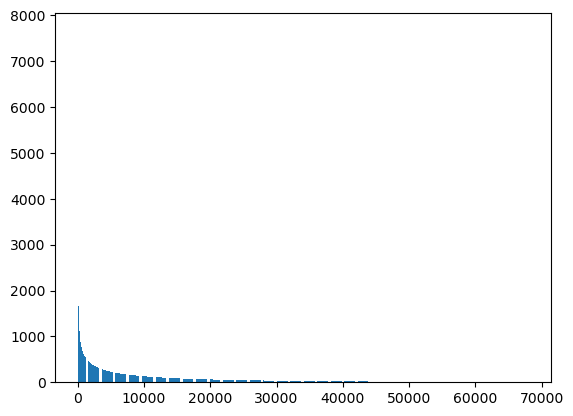

In [34]:
plt.bar(np.arange(review_count_by_business.shape[0]), review_count_by_business);

We observe that some restaurants do receive very large quantities of reviews while others do not.

However, mitigating class imbalance in our case can be extremely challenging. Because the number of reviews acts as an indicator for popularity, under-sampling some of the popular restaurants will likely hurt the performance of our model. Similarly, for small restaurants with very few reviews, artifitically generating more records such as using SMOTE may introduce too much bias (this seems somewhat equivalent to writing fake reviews to inflate or deflate a restaurant's popularity).

Due to these concerns, it appears that we have a reason to preserve the class imbalance. Hence, we will not be performing any resampling at the moment, but we could certainly revisit this step in the future to investigate how resampling affects model performance.

### Save processed data

In [36]:
review_clean_df.reset_index(drop=True).to_feather('data/yelp_review_cleaned.feather')